# Phase 1 Requirements  
### Preprocessing of the captured image. (10 marks) 
### Credit card frame detection. (5 marks) 
### Straightening and cropping the picture such that it only contains the undistorted PAN. (5 marks) 

# Imports

In [1]:
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt

### Define a dictionary that maps the first digit of a credit card number to the credit card type

In [2]:
FIRST_NUMBER = {
	"3": "American Express",
	"4": "Visa",
	"5": "MasterCard",
	"6": "Discover Card"
}

### List of all The Test cases 

In [3]:
testcases = [cv2.imread('./testcases/01 - Straightforward.jpg'),
       cv2.imread('./testcases/02 - You can do it.jpg'),
       cv2.imread('./testcases/03 - Should be okay.jpg'),
       cv2.imread('./testcases/04 - Still ok, I hope.jpg'),
       cv2.imread('./testcases/05 - Looks cool, hope it runs cool too.jpg'),
       cv2.imread('./testcases/06 - Hatetlewe7 hatlewe7.jpg'),
       cv2.imread('./testcases/07 - Hatet3eweg hat3eweg.jpg'),
       cv2.imread('./testcases/08 - Ew3a soba3ak ya3am.jpg'),
       cv2.imread('./testcases/09 - El spero spathis we23et 3aaaa.jpg'),
      cv2.imread('./testcases/10 - Mal7 w Felfel.jpg'),
       cv2.imread('./testcases/11 - Ya setty ew3i.jpg'),
       cv2.imread('./testcases/12 - weewooweewoo.jpg') ,
       cv2.imread('./testcases/13 - Matozbot el camera ya Kimo.jpg'),
      cv2.imread('./testcases/14 - 2el noor 2ata3.jpg'),
       cv2.imread('./testcases/15 - Compresso Espresso.jpg'),
       cv2.imread('./testcases/16 - Sheel el kart yastaaaa.jpg'),
            ]

## Kernel

In [4]:
# initialize a rectangular (wider than it is tall) and square
# structuring kernel
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))
# Create a smaller rectangular structuring element with size 5x2
smallRectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 2))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

## Preprocess Image
### Define a function to preprocess the image, including resizing, grayscaling, and blurring.

In [5]:
def preprocess_image(image):
    # Read and resize the image
    image = imutils.resize(image, width=500)

    # Add padding to the image
    image = cv2.copyMakeBorder(image, 20, 20, 20, 20, cv2.BORDER_CONSTANT, value=(255, 255, 255))

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  
    # Apply median blur multiple times with varying kernel sizes
    blurred = cv2.medianBlur(gray, 5)
    blurred = cv2.medianBlur(blurred, 5)
    blurred = cv2.medianBlur(blurred, 5)
    
    blurred = cv2.medianBlur(blurred, 7)
    blurred = cv2.medianBlur(blurred, 7)
    
    blurred = cv2.GaussianBlur(blurred, (3, 3), 0)
    
    
    #Histogram_before = cv2.calcHist([blurred], [0], None, [256], [0, 256])

    # plt.plot(Histogram_before, color='gray')
    # plt.xlabel('Pixel Value')
    # plt.ylabel('Frequency')

    # Apply histogram equalization to enhance the contrast
    #Comment this ==> for better card contour for now 
    # proceed_image = cv2.equalizeHist(blurred)
    
    # 
    # Histogram_after  = cv2.calcHist([blurred], [0], None, [256], [0, 256])
    # 
    # plt.plot(Histogram_after, color='gray')
    # plt.xlabel('Pixel Value')
    # plt.ylabel('Frequency')
    
    # plt.imshow(gray, cmap='gray')
    # plt.title('before preprocessed Image')
    # plt.axis('off')  # Hide the axis
    # 
    # 
    # plt.imshow(blurred, cmap='gray')
    # plt.title('After preprocessed Image')
    # plt.axis('off')  # Hide the axis
    
    proceed_image = blurred
    

    return image, proceed_image



## Find Card Contour

### Define a function to find the contour of the credit card.

In [6]:
def find_card_contour(blurred):
    # Edge detection using Canny
    edges = cv2.Canny(blurred, 30, 150)

    # Dilation and erosion to close gaps in edges

    
    edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, rectKernel)


    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort the contours by area and find the largest contour
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    for contour in contours:
        # Filter out contours that are too small to be the card
        area = cv2.contourArea(contour)
        if area < 5000:  # Adjust this threshold based on image size
            continue

        # Approximate the contour
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * peri, True)

        # If the contour has four points, we can assume it's the card
        if len(approx) == 4:
            # Check the aspect ratio to ensure it's likely a card
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = w / float(h)
            if 0.5 < aspect_ratio < 2.0:  # Aspect ratio for cards is typically around 1.5 (landscape)
                return approx

    return None


## Perspective Transformation

### Define a function to apply perspective transformation to straighten the image of the credit card.

In [7]:
def perspective_transform(image, contour):
    # Order the points in the contour
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype="float32")

    # Top-left point has the smallest sum, bottom-right has the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # Top-right has the smallest difference, bottom-left has the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # Compute the width and height of the new image
    (tl, tr, br, bl) = rect
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # Destination points for the perspective transform
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    # Compute the perspective transform matrix and apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    return warped

## Utils Function
### Show Images Plot 

In [8]:
def show_images(images, titles):
    plt.figure(figsize=(15, 5))
    for i, (imageplace, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(imageplace, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


# Main Function 

## All Images Function Call

0


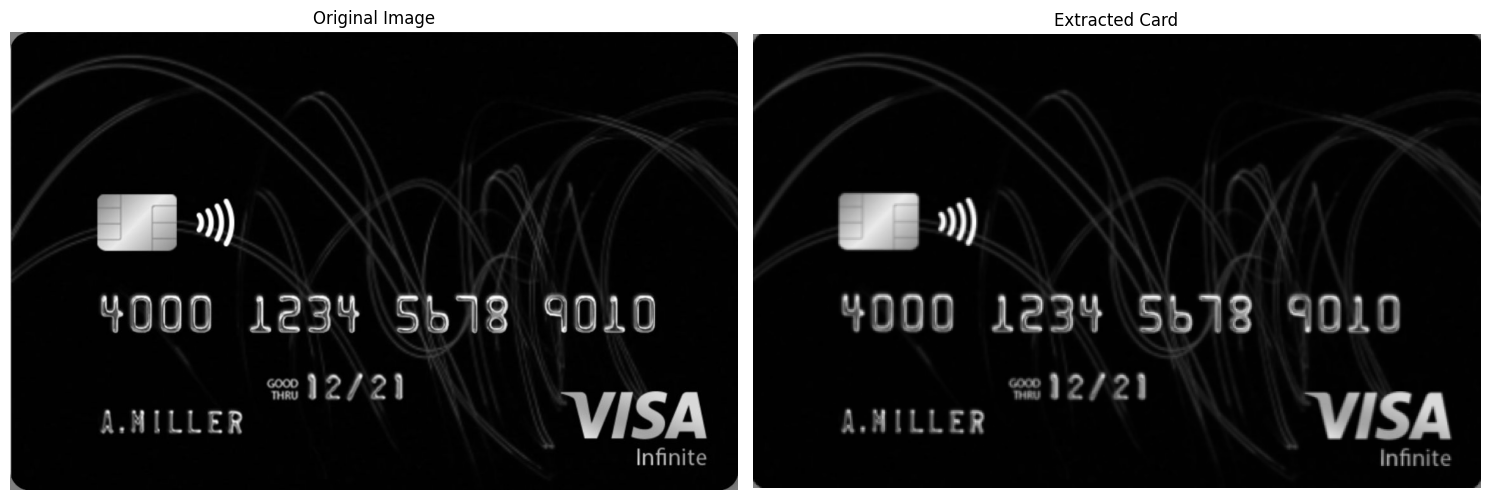

1


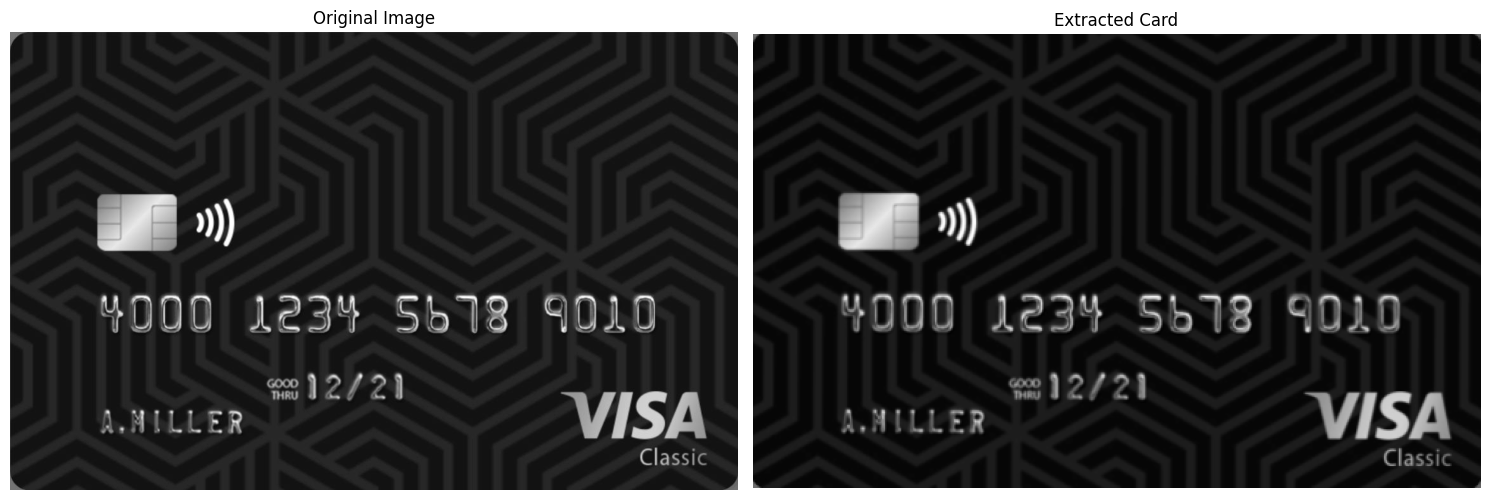

2


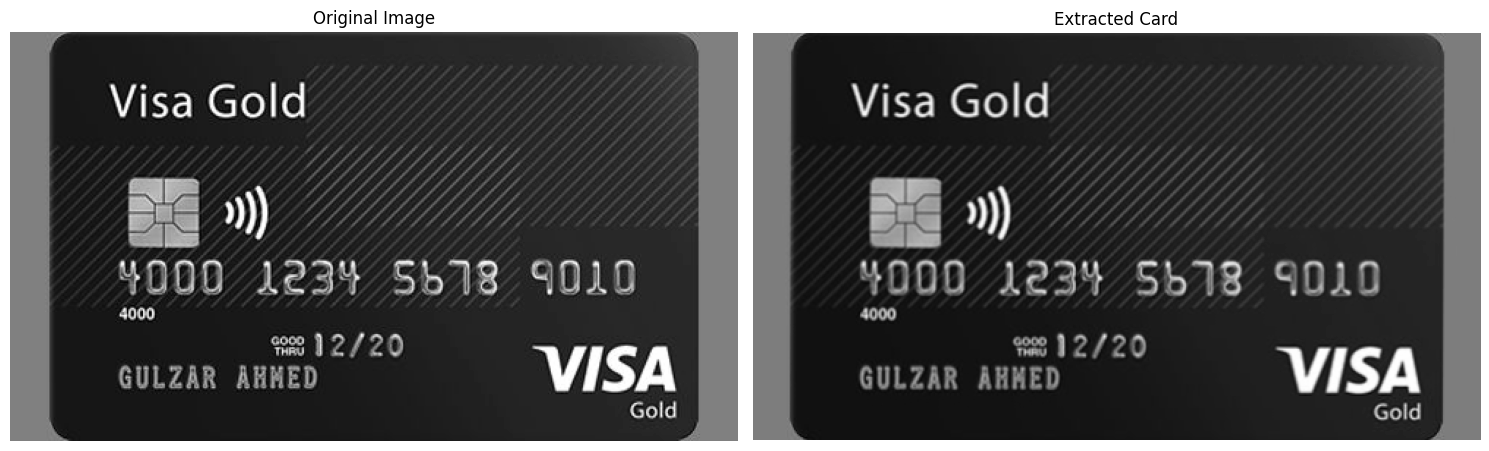

3


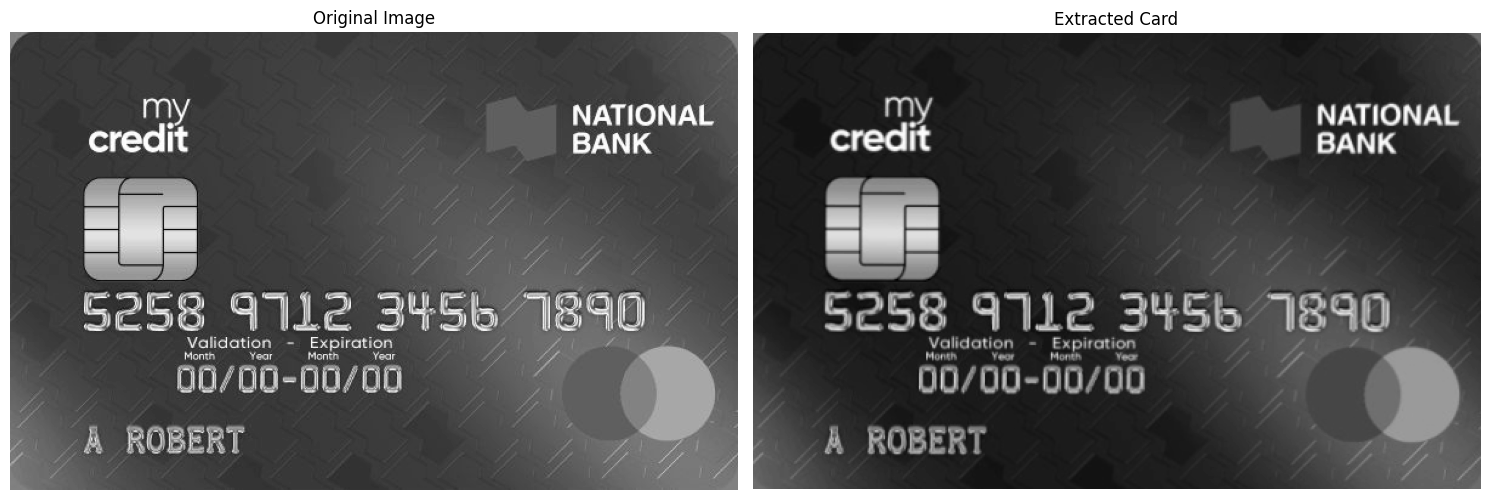

4


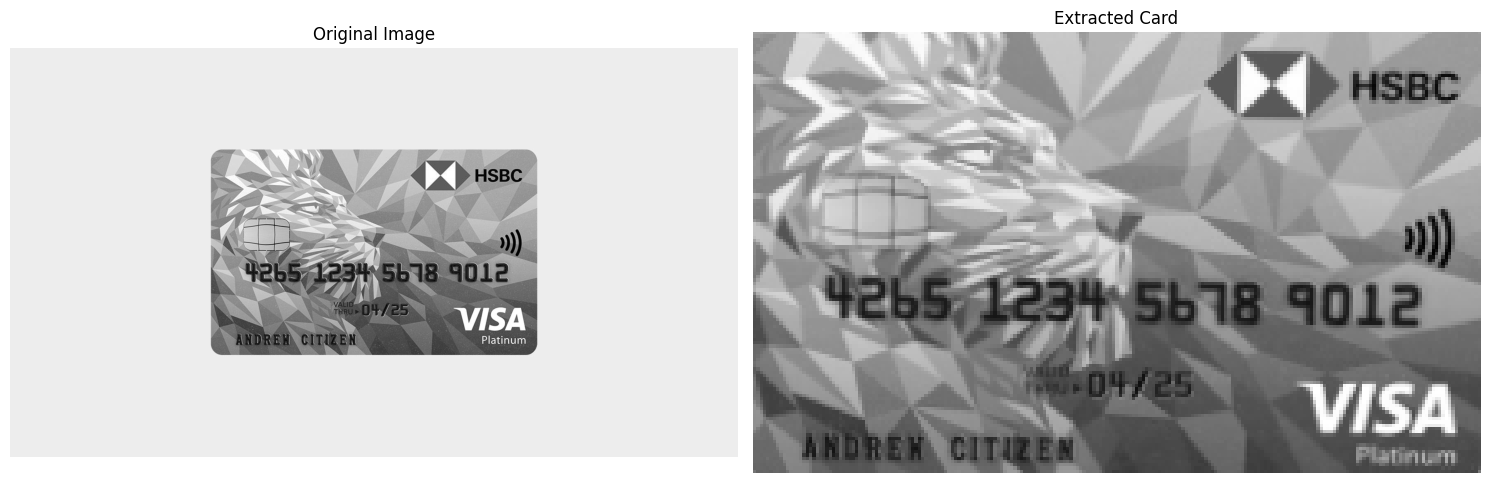

5
No card found
6


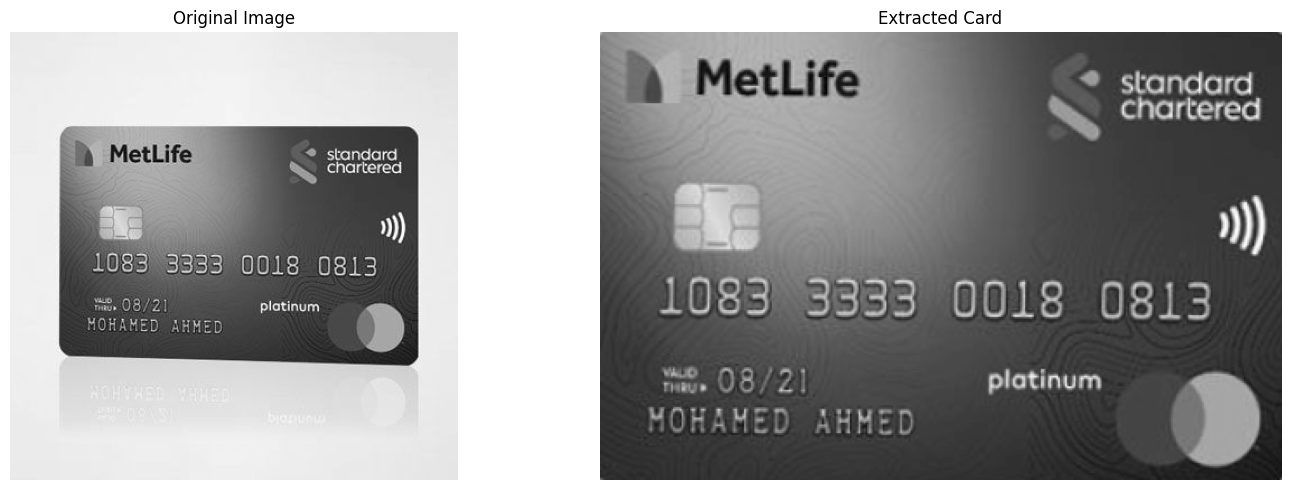

7
No card found
8
No card found
9


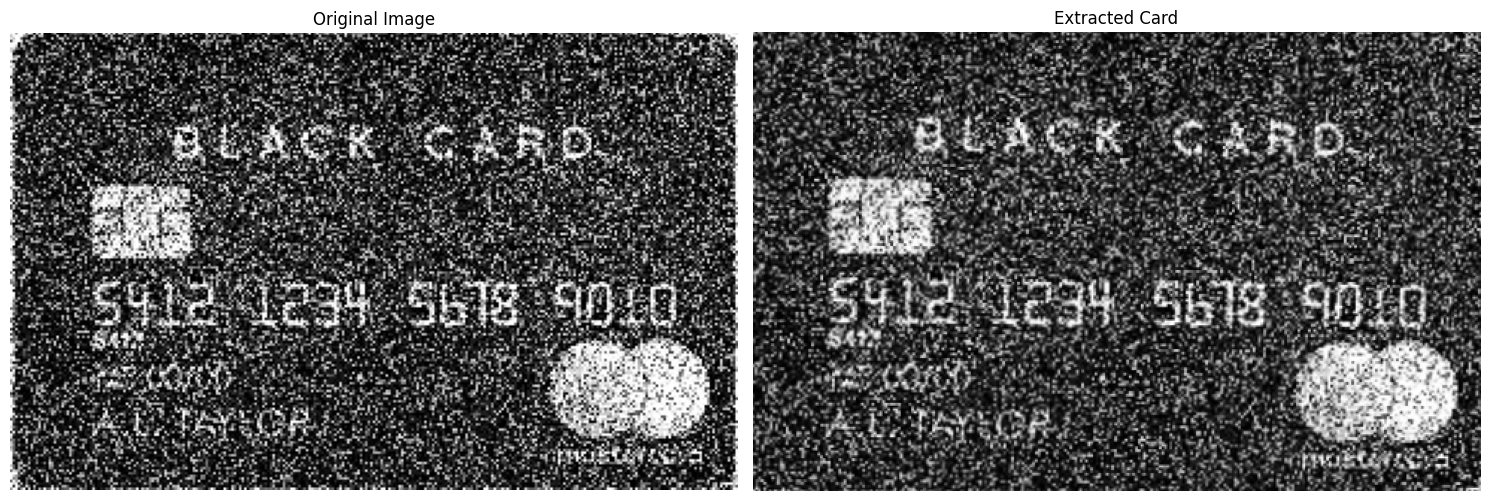

10
No card found
11


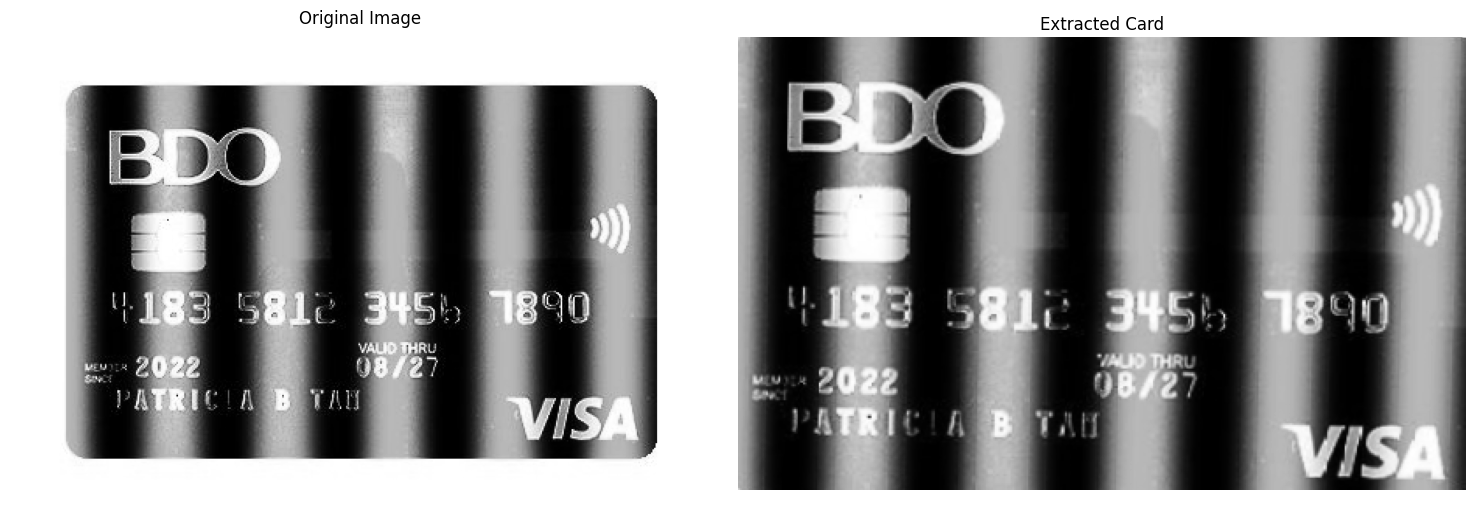

12


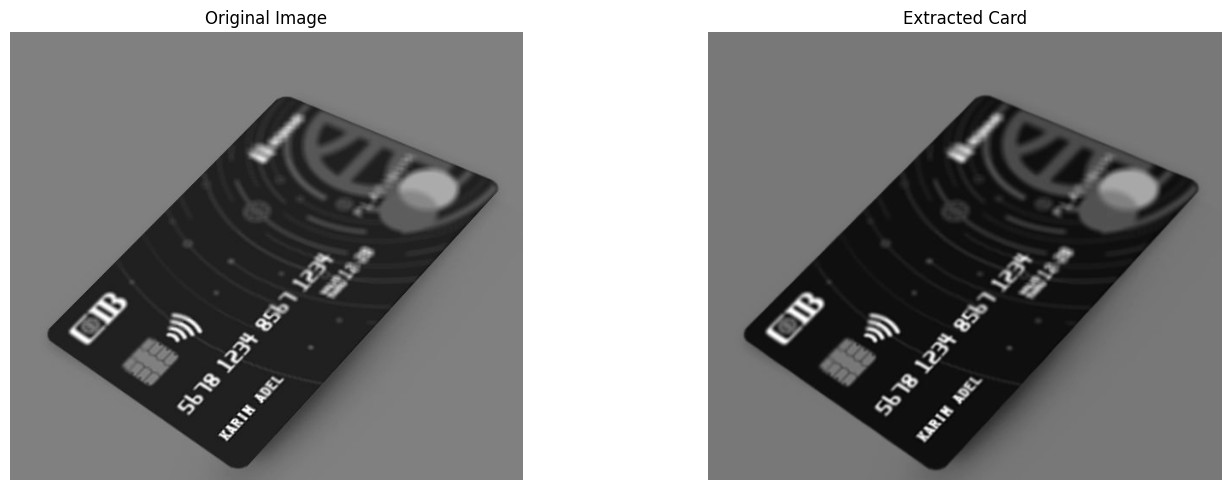

13


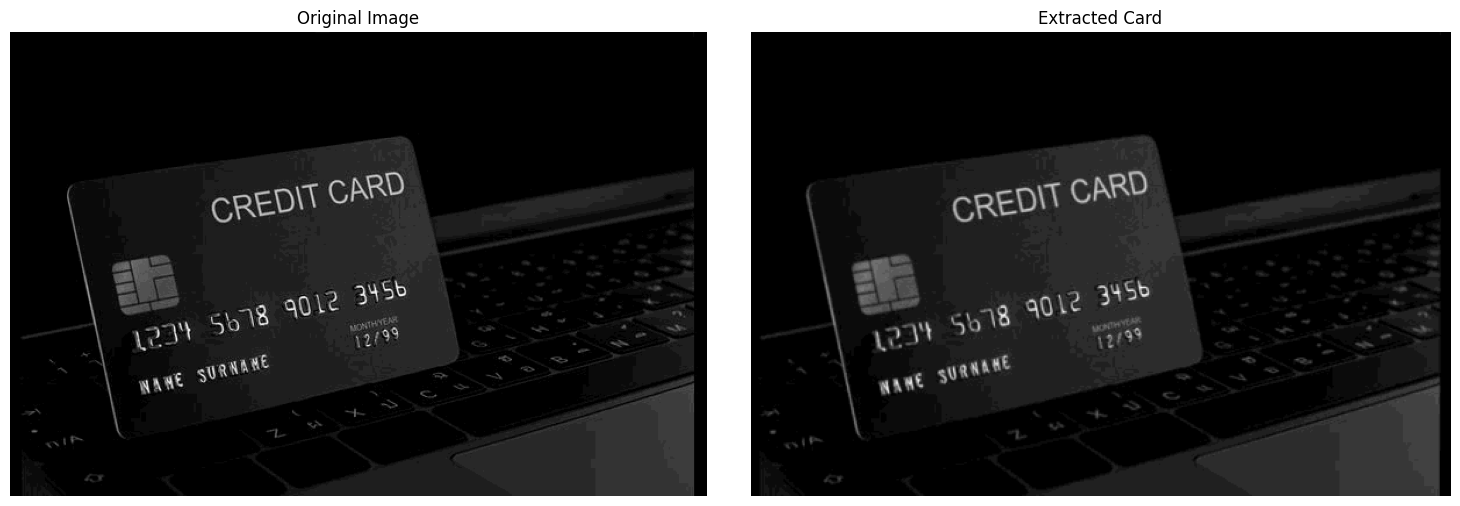

14


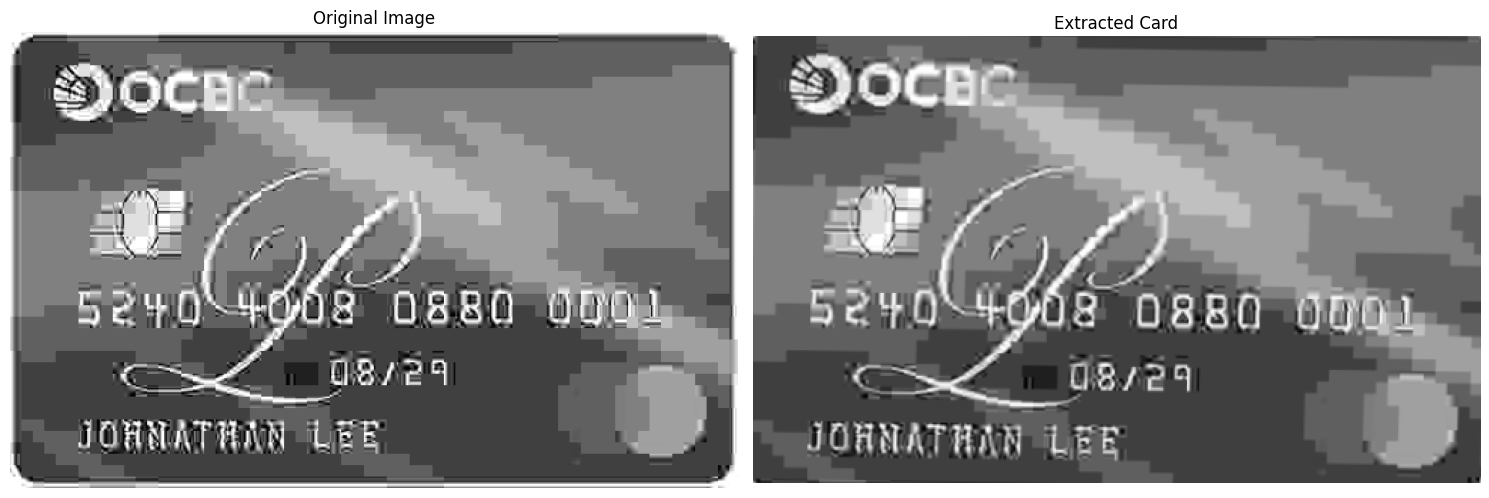

15


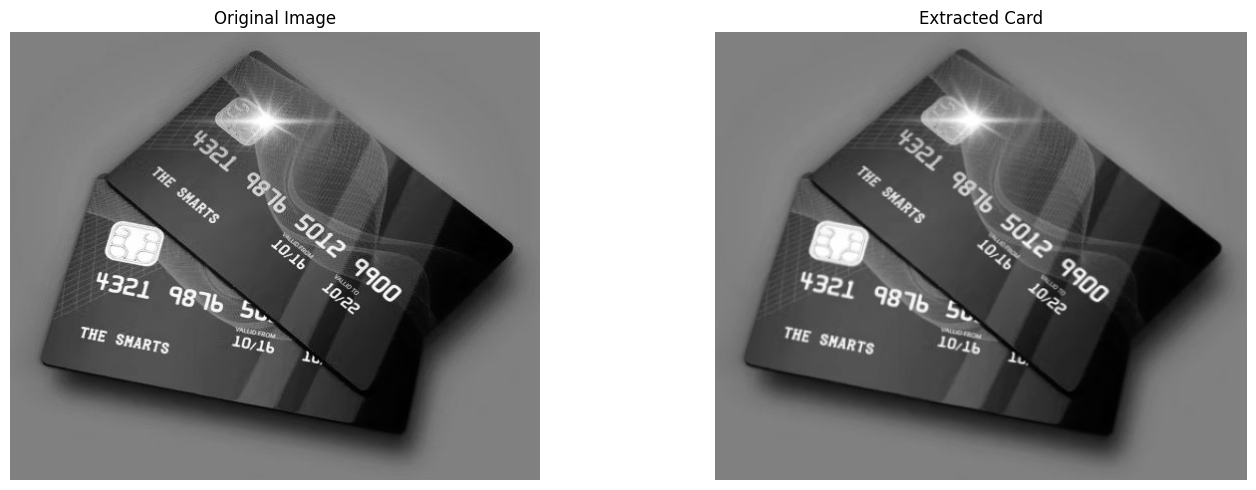

In [9]:
for  i in range(len(testcases)):
    print(i)
    image = testcases[i]
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image, blurred_image = preprocess_image(image)
    card_contour = find_card_contour(blurred_image)
    if card_contour is not None :
        card_image = perspective_transform(image , card_contour)
        card_image = imutils.resize(card_image)
        card_image_gray = cv2.cvtColor(card_image, cv2.COLOR_BGR2GRAY)
        show_images([ gray , card_image_gray], ['Original Image', 'Extracted Card'])
    else :
        print("No card found")


##  Single Image Function Call

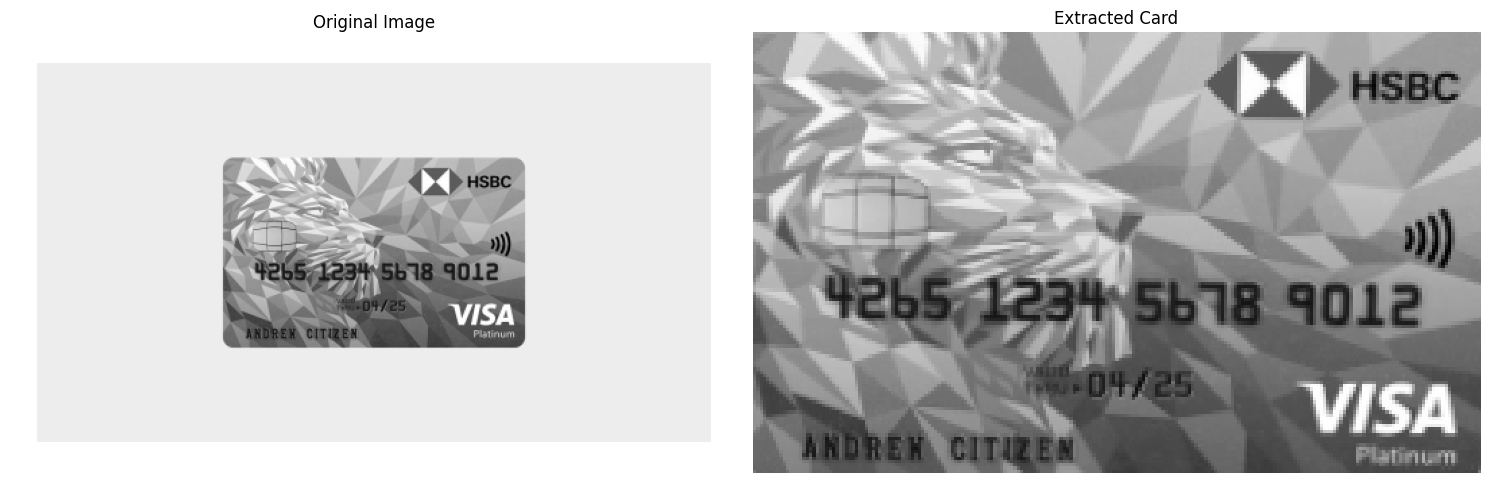

In [10]:
image = testcases[4]
image, blurred_image = preprocess_image(image)
card_contour = find_card_contour(blurred_image)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
if card_contour is not None :
    card_image = perspective_transform(image , card_contour)
    card_image = imutils.resize(card_image)
    card_image_gray = cv2.cvtColor(card_image, cv2.COLOR_BGR2GRAY)
    show_images([ gray , card_image_gray], ['Original Image', 'Extracted Card'])
else :
    print("No card found")
